# Machine Learning Engineer Nanodegree
## Unsupervised Learning
## Project 3: Creating Customer Segments

Welcome to the third project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

## Getting Started

In this project, you will analyze a dataset containing data on various customers' annual spending amounts (reported in *monetary units*) of diverse product categories for internal structure. One goal of this project is to best describe the variation in the different types of customers that a wholesale distributor interacts with. Doing so would equip the distributor with insight into how to best structure their delivery service to meet the needs of each customer.

The dataset for this project can be found on the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wholesale+customers). For the purposes of this project, the features `'Channel'` and `'Region'` will be excluded in the analysis — with focus instead on the six product categories recorded for customers.

Run the code block below to load the wholesale customers dataset, along with a few of the necessary Python libraries required for this project. You will know the dataset loaded successfully if the size of the dataset is reported.

In [1]:
# Import libraries necessary for this project
import numpy as np
import pandas as pd
import renders as rs
from IPython.display import display # Allows the use of display() for DataFrames

# Show matplotlib plots inline (nicely formatted in the notebook)
%matplotlib inline

# Load the wholesale customers dataset
try:
    data = pd.read_csv("customers.csv")
    data.drop(['Region', 'Channel'], axis = 1, inplace = True)
    print "Wholesale customers dataset has {} samples with {} features each.".format(*data.shape)
except:
    print "Dataset could not be loaded. Is the dataset missing?"

Wholesale customers dataset has 440 samples with 6 features each.


In [2]:
# Further imports and global variables
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeRegressor
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.mixture import GMM
from sklearn.metrics import silhouette_score

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

RANDOM_STATE = 42

## Data Exploration
In this section, you will begin exploring the data through visualizations and code to understand how each feature is related to the others. You will observe a statistical description of the dataset, consider the relevance of each feature, and select a few sample data points from the dataset which you will track through the course of this project.

Run the code block below to observe a statistical description of the dataset. Note that the dataset is composed of six important product categories: **'Fresh'**, **'Milk'**, **'Grocery'**, **'Frozen'**, **'Detergents_Paper'**, and **'Delicatessen'**. Consider what each category represents in terms of products you could purchase.

In [3]:
# Display a description of the dataset
display(data.describe())

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### Implementation: Selecting Samples
To get a better understanding of the customers and how their data will transform through the analysis, it would be best to select a few sample data points and explore them in more detail. In the code block below, add **three** indices of your choice to the `indices` list which will represent the customers to track. It is suggested to try different sets of samples until you obtain customers that vary significantly from one another.

In [4]:
# TODO: Select three indices of your choice you wish to sample from the dataset
indices = [47, 150, 351]

# Create a DataFrame of the chosen samples
samples = pd.DataFrame(data.loc[indices], columns = data.keys()).reset_index(drop = True)
print "Chosen samples of wholesale customers dataset:"
display(samples)

Chosen samples of wholesale customers dataset:


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,44466,54259,55571,7782,24171,6465
1,16225,1825,1765,853,170,1067
2,1210,10044,22294,1741,12638,3137


### Question 1
Consider the total purchase cost of each product category and the statistical description of the dataset above for your sample customers.  
*What kind of establishment (customer) could each of the three samples you've chosen represent?*  
**Hint:** Examples of establishments include places like markets, cafes, and retailers, among many others. Avoid using names for establishments, such as saying *"McDonalds"* when describing a sample customer as a restaurant.

**Answer:**
The first sample has numbers far above the mean across the board, mostly by many standard deviations. To me this indicates a large supermarket type store, which would be reselling a large variety and volume. The second sample spends a lot on fresh products, being well over the mean and just about in the 75th percentile. It's also over the median on delicatessen. However, it's well below the median on the rest, suggesting a resaurant preparing fresh food with very little resale. The third sample is similar to the first, besides having lower spending overall, except in Fresh which is very low, not even in the 25th percentile. This suggests a corner store to me, somewhere with high resale but low turnover.

### Implementation: Feature Relevance
One interesting thought to consider is if one (or more) of the six product categories is actually relevant for understanding customer purchasing. That is to say, is it possible to determine whether customers purchasing some amount of one category of products will necessarily purchase some proportional amount of another category of products? We can make this determination quite easily by training a supervised regression learner on a subset of the data with one feature removed, and then score how well that model can predict the removed feature.

In the code block below, you will need to implement the following:
 - Assign `new_data` a copy of the data by removing a feature of your choice using the `DataFrame.drop` function.
 - Use `sklearn.cross_validation.train_test_split` to split the dataset into training and testing sets.
   - Use the removed feature as your target label. Set a `test_size` of `0.25` and set a `random_state`.
 - Import a decision tree regressor, set a `random_state`, and fit the learner to the training data.
 - Report the prediction score of the testing set using the regressor's `score` function.

In [5]:
# TODO: Make a copy of the DataFrame, using the 'drop' function to drop the given feature
new_data = data.drop('Milk',axis=1)
new_target = data['Milk']
"""
# TODO: Split the data into training and testing sets using the given feature as the target
X_train, X_test, y_train, y_test = train_test_split(new_data, new_target, test_size = .25, random_state=RANDOM_STATE)

# TODO: Create a decision tree regressor and fit it to the training set
regressor = DecisionTreeRegressor(random_state=RANDOM_STATE)
regressor.fit(X_train,y_train)

# TODO: Report the score of the prediction using the testing set
score = regressor.score(X_test,y_test)
"""

# Since the random_state of the split has a large impact on the result, a better idea of the true score can be obtained by 
# testing a range of random_state and averaging the resulting scores
scores = []
for n in range(1,101,1):
    X_train, X_test, y_train, y_test = train_test_split(new_data, new_target, test_size = .25, random_state=n)
    regressor = DecisionTreeRegressor(random_state=n)
    regressor.fit(X_train,y_train)
    scores.append(regressor.score(X_test,y_test))


print np.mean(scores)

0.138850161189


### Question 2
*Which feature did you attempt to predict? What was the reported prediction score? Is this feature is necessary for identifying customers' spending habits?*  
**Hint:** The coefficient of determination, `R^2`, is scored between 0 and 1, with 1 being a perfect fit. A negative `R^2` implies the model fails to fit the data.

**Answer:**
I attempted to predict Milk. The reported score was 0.139, which says the feature is somewhat predicted by the rest of the data but not enough to justify removing it outright. However, since I don't know how to stratify the data in a continuous dataset, random_state has a significant impact on this result and it's not especially meaningful.

### Visualize Feature Distributions
To get a better understanding of the dataset, we can construct a scatter matrix of each of the six product features present in the data. If you found that the feature you attempted to predict above is relevant for identifying a specific customer, then the scatter matrix below may not show any correlation between that feature and the others. Conversely, if you believe that feature is not relevant for identifying a specific customer, the scatter matrix might show a correlation between that feature and another feature in the data. Run the code block below to produce a scatter matrix.

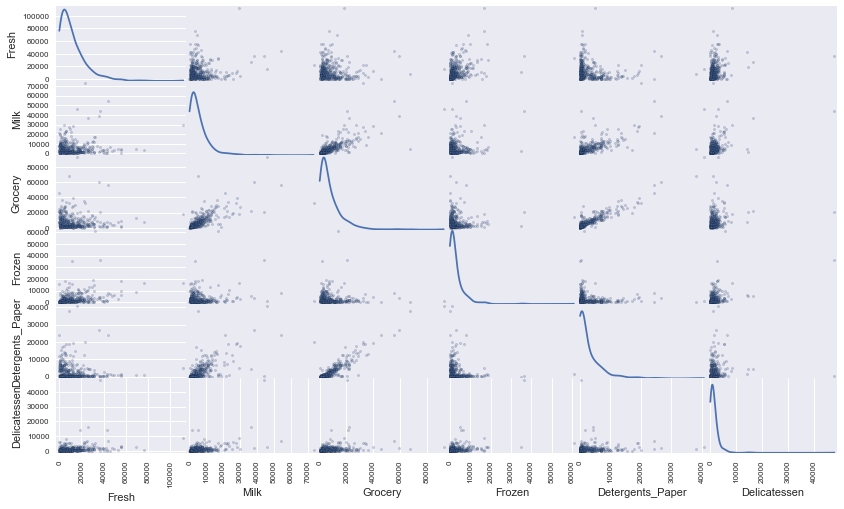

In [6]:
# Produce a scatter matrix for each pair of features in the data
pd.scatter_matrix(data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Question 3
*Are there any pairs of features which exhibit some degree of correlation? Does this confirm or deny your suspicions about the relevance of the feature you attempted to predict? How is the data for those features distributed?*  
**Hint:** Is the data normally distributed? Where do most of the data points lie? 

**Answer:**
Yes, Milk appears to be correlated with Grocery and Detergents_Paper, and I'd even say slightly with a small subset of Fresh. This confirms my suspicions about Milk - that it'd be an odd thing to specialize in - and the correlations all look fairly linear. Outliers in each feature make it hard to judge the distributions at this scale, but between features that don't look correlated it almost seem to be a double gaussian.

## Data Preprocessing
In this section, you will preprocess the data to create a better representation of customers by performing a scaling on the data and detecting (and optionally removing) outliers. Preprocessing data is often times a critical step in assuring that results you obtain from your analysis are significant and meaningful.

### Implementation: Feature Scaling
If data is not normally distributed, especially if the mean and median vary significantly (indicating a large skew), it is most [often appropriate](http://econbrowser.com/archives/2014/02/use-of-logarithms-in-economics) to apply a non-linear scaling — particularly for financial data. One way to achieve this scaling is by using a [Box-Cox test](http://scipy.github.io/devdocs/generated/scipy.stats.boxcox.html), which calculates the best power transformation of the data that reduces skewness. A simpler approach which can work in most cases would be applying the natural logarithm.

In the code block below, you will need to implement the following:
 - Assign a copy of the data to `log_data` after applying a logarithm scaling. Use the `np.log` function for this.
 - Assign a copy of the sample data to `log_samples` after applying a logrithm scaling. Again, use `np.log`.

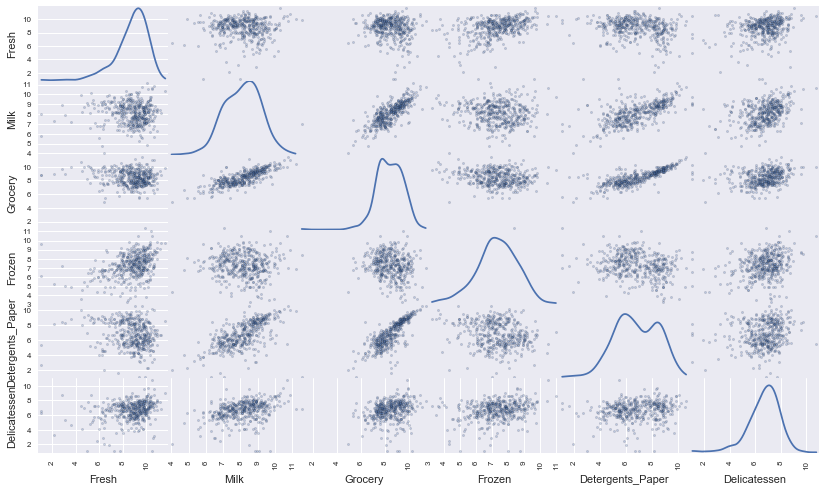

In [7]:
# TODO: Scale the data using the natural logarithm
log_data = data.applymap(np.log)

# TODO: Scale the sample data using the natural logarithm
log_samples = samples.applymap(np.log)

# Produce a scatter matrix for each pair of newly-transformed features
pd.scatter_matrix(log_data, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Observation
After applying a natural logarithm scaling to the data, the distribution of each feature should appear much more normal. For any pairs of features you may have identified earlier as being correlated, observe here whether that correlation is still present (and whether it is now stronger or weaker than before).

Run the code below to see how the sample data has changed after having the natural logarithm applied to it.

In [8]:
# Display the log-transformed sample data
display(log_samples)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,10.702480,10.901524,10.925417,8.959569,10.092909,8.774158
1,9.694309,7.509335,7.475906,6.748760,5.135798,6.972606
2,7.098376,9.214731,10.012073,7.462215,9.444463,8.051022


### Implementation: Outlier Detection
Detecting outliers in the data is extremely important in the data preprocessing step of any analysis. The presence of outliers can often skew results which take into consideration these data points. There are many "rules of thumb" for what constitutes an outlier in a dataset. Here, we will use [Tukey's Method for identfying outliers](http://datapigtechnologies.com/blog/index.php/highlighting-outliers-in-your-data-with-the-tukey-method/): An *outlier step* is calculated as 1.5 times the interquartile range (IQR). A data point with a feature that is beyond an outlier step outside of the IQR for that feature is considered abnormal.

In the code block below, you will need to implement the following:
 - Assign the value of the 25th percentile for the given feature to `Q1`. Use `np.percentile` for this.
 - Assign the value of the 75th percentile for the given feature to `Q3`. Again, use `np.percentile`.
 - Assign the calculation of an outlier step for the given feature to `step`.
 - Optionally remove data points from the dataset by adding indices to the `outliers` list.

**NOTE:** If you choose to remove any outliers, ensure that the sample data does not contain any of these points!  
oOnce you have performed this implementation, the dataset will be stored in the variable `good_data`.

In [9]:
outlier_dict = {}
outlier_count = Counter()

# For each feature find the data points with extreme high or low values
for feature in log_data.keys():
    # TODO: Calculate Q1 (25th percentile of the data) for the given feature
    Q1 = np.percentile(log_data[feature],25)
    
    # TODO: Calculate Q3 (75th percentile of the data) for the given feature
    Q3 = np.percentile(log_data[feature],75)
    
    # TODO: Use the interquartile range to calculate an outlier step (1.5 times the interquartile range)
    step = 1.5*(Q3-Q1)
    
    # Store outliers by feature
    outlier_dict[feature] = log_data[~((log_data[feature] >= Q1 - step) & (log_data[feature] <= Q3 + step))]
    
    # Count outlier occurances within feature, add to total
    c = Counter(outlier_dict[feature].index.values)
    outlier_count = outlier_count + c
    
    # Display the outliers
    print "Data points considered outliers for the feature '{}':".format(feature)
    display(outlier_dict[feature])
    
# OPTIONAL: Select the indices for data points you wish to remove
outliers = []

# Add duplicate outliers
for key in outlier_count:
    if outlier_count[key] > 1:
        outliers.append(key)

# Manually add outliers, see below for selection process
outliers= outliers + [86,183,325,95,96,218,338,357,98,356,38,57,145,175,264,420,429,439,161,109,142,184,187,203,233,285]

# Remove the outliers, if any were specified
good_data = log_data.drop(log_data.index[outliers]).reset_index(drop = True)

Data points considered outliers for the feature 'Fresh':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
81,5.389072,9.163249,9.575192,5.645447,8.964184,5.049856
95,1.098612,7.979339,8.740657,6.086775,5.407172,6.563856
96,3.135494,7.869402,9.001839,4.976734,8.262043,5.379897
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
171,5.298317,10.160530,9.894245,6.478510,9.079434,8.740337
193,5.192957,8.156223,9.917982,6.865891,8.633731,6.501290
218,2.890372,8.923191,9.629380,7.158514,8.475746,8.759669
304,5.081404,8.917311,10.117510,6.424869,9.374413,7.787382


Data points considered outliers for the feature 'Milk':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
86,10.039983,11.205013,10.377047,6.894670,9.906981,6.805723
98,6.220590,4.718499,6.656727,6.796824,4.025352,4.882802
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
356,10.029503,4.897840,5.384495,8.057377,2.197225,6.306275


Data points considered outliers for the feature 'Grocery':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442


Data points considered outliers for the feature 'Frozen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
38,8.431853,9.663261,9.723703,3.496508,8.847360,6.070738
57,8.597297,9.203618,9.257892,3.637586,8.932213,7.156177
65,4.442651,9.950323,10.732651,3.583519,10.095388,7.260523
145,10.000569,9.034080,10.457143,3.737670,9.440738,8.396155
175,7.759187,8.967632,9.382106,3.951244,8.341887,7.436617
264,6.978214,9.177714,9.645041,4.110874,8.696176,7.142827
325,10.395650,9.728181,9.519735,11.016479,7.148346,8.632128
420,8.402007,8.569026,9.490015,3.218876,8.827321,7.239215
429,9.060331,7.467371,8.183118,3.850148,4.430817,7.824446
439,7.932721,7.437206,7.828038,4.174387,6.167516,3.951244


Data points considered outliers for the feature 'Detergents_Paper':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
75,9.923192,7.036148,1.098612,8.390949,1.098612,6.882437
161,9.428190,6.291569,5.645447,6.995766,1.098612,7.711101


Data points considered outliers for the feature 'Delicatessen':


,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
66,2.197225,7.335634,8.911530,5.164786,8.151333,3.295837
109,7.248504,9.724899,10.274568,6.511745,6.728629,1.098612
128,4.941642,9.087834,8.248791,4.955827,6.967909,1.098612
137,8.034955,8.997147,9.021840,6.493754,6.580639,3.583519
142,10.519646,8.875147,9.018332,8.004700,2.995732,1.098612
154,6.432940,4.007333,4.919981,4.317488,1.945910,2.079442
183,10.514529,10.690808,9.911952,10.505999,5.476464,10.777768
184,5.789960,6.822197,8.457443,4.304065,5.811141,2.397895
187,7.798933,8.987447,9.192075,8.743372,8.148735,1.098612
203,6.368187,6.529419,7.703459,6.150603,6.860664,2.890372


### Question 4
*Are there any data points considered outliers for more than one feature based on the definition above? Should these data points be removed from the dataset? If any data points were added to the `outliers` list to be removed, explain why.* 

**Answer:**  
*Are there any data points considered outliers for more than one feature based on the definition above?*  
There are: 65, 66, 75, 128, 154

*Should these data points be removed from the dataset?*  
Yes. We're trying to model a typical customer and having multiple outliers like this makes it very likely the sample will pull the clustering center away from that ideal.

*If any data points were added to the `outliers` list to be removed, explain why.*  
As I suspected in Question 3, the plot of the log data shows that most of the features have a double gaussian distribution to varying extents. As such the IQR might not be the ideal method for removing outliers as it only considers the distribution of the entire datset. That is to say, samples may actually be explained by one of the gaussians despite falling outside the IQR. Because of this I removed most but not all of the outliers listed, with exceptions for samples very close to the lower bound. I decided what 'very close' meant by eye, which I feel justified doing since 1.5\*IQR is arbitrary anyway.

## Feature Transformation
In this section you will use principal component analysis (PCA) to draw conclusions about the underlying structure of the wholesale customer data. Since using PCA on a dataset calculates the dimensions which best maximize variance, we will find which compound combinations of features best describe customers.

### Implementation: PCA

Now that the data has been scaled to a more normal distribution and has had any necessary outliers removed, we can now apply PCA to the `good_data` to discover which dimensions about the data best maximize the variance of features involved. In addition to finding these dimensions, PCA will also report the *explained variance ratio* of each dimension — how much variance within the data is explained by that dimension alone. Note that a component (dimension) from PCA can be considered a new "feature" of the space, however it is a composition of the original features present in the data.

In the code block below, you will need to implement the following:
 - Import `sklearn.decomposition.PCA` and assign the results of fitting PCA in six dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

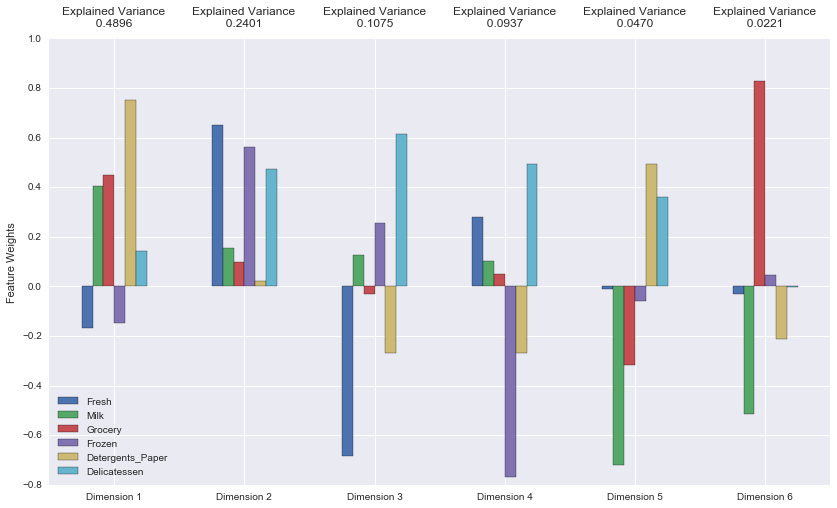

In [10]:
# TODO: Apply PCA by fitting the good data with the same number of dimensions as features
pca = PCA()
pca.fit(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Generate PCA results plot
pca_results = rs.pca_results(good_data, pca)

### Question 5
*How much variance in the data is explained* ***in total*** *by the first and second principal component? What about the first four principal components? Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
**Hint:** A positive increase in a specific dimension corresponds with an *increase* of the *positive-weighted* features and a *decrease* of the *negative-weighted* features. The rate of increase or decrease is based on the indivdual feature weights.

**Answer:**  
*How much variance in the data is explained* ***in total*** *by the first and second principal component?*  
0.4896+0.2401 = 0.7297

*What about the first four principal components?*  
0.7297+0.1075+0.0937 = 0.9309

*Using the visualization provided above, discuss what the first four dimensions best represent in terms of customer spending.*  
 The first is the correlation between Milk, Grocery, and Detergents_Paper we observed earlier, measuring customers for whom these are the predominant purchases. I would guess this is a measure of retail, these being the sorts of things found in shops like supermarkets. The decrease relative to frozen spending is a bit surprising though.  
 The second is a correlation between Fresh, Frozen, and Delicatessen, which I'd be pretty hard pressed to spot in the scatter plots. Again this measures customers for whom these are the dominant spending categories, which sound like resaurants and delis who sell prepared foods.  
 The third and fourth are, in a sense, special cases that counter the first two. That is to say, the third shows Frozen and Delicatessen with an inverse correlation to Fresh and Detergents_Paper, i.e. customers for whom Delicatessen spending matters a lot more when Fresh spending is low. The fourth is a similar inverse correlation of Frozen and Detergents_Paper with Delicatessen and Fresh. These could both be representing stores like cafes or coffee shops that resell deli food without preparing or storing much themselves.

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it in six dimensions. Observe the numerical value for the first four dimensions of the sample points. Consider if this is consistent with your initial interpretation of the sample points.

In [11]:
# Display sample log-data after having a PCA transformation applied
display(pd.DataFrame(np.round(pca_samples, 4), columns = pca_results.index.values))

,Dimension 1,Dimension 2,Dimension 3,Dimension 4,Dimension 5,Dimension 6
0,4.4514,3.7784,-0.2338,-0.1670,-0.5564,-0.0632
1,-1.9591,0.0540,-0.2074,1.1765,0.0311,-0.1756
2,3.5885,-0.1208,1.3951,-0.4234,0.4903,0.2386


### Implementation: Dimensionality Reduction
When using principal component analysis, one of the main goals is to reduce the dimensionality of the data — in effect, reducing the complexity of the problem. Dimensionality reduction comes at a cost: Fewer dimensions used implies less of the total variance in the data is being explained. Because of this, the *cumulative explained variance ratio* is extremely important for knowing how many dimensions are necessary for the problem. Additionally, if a signifiant amount of variance is explained by only two or three dimensions, the reduced data can be visualized afterwards.

In the code block below, you will need to implement the following:
 - Assign the results of fitting PCA in two dimensions with `good_data` to `pca`.
 - Apply a PCA transformation of `good_data` using `pca.transform`, and assign the reuslts to `reduced_data`.
 - Apply a PCA transformation of the sample log-data `log_samples` using `pca.transform`, and assign the results to `pca_samples`.

In [12]:
# TODO: Apply PCA by fitting the good data with only two dimensions
pca = PCA(n_components=2)
pca = pca.fit(good_data)

# TODO: Transform the good data using the PCA fit above
reduced_data = pca.transform(good_data)

# TODO: Transform the sample log-data using the PCA fit above
pca_samples = pca.transform(log_samples)

# Create a DataFrame for the reduced data
reduced_data = pd.DataFrame(reduced_data, columns = ['Dimension 1', 'Dimension 2'])

### Observation
Run the code below to see how the log-transformed sample data has changed after having a PCA transformation applied to it using only two dimensions. Observe how the values for the first two dimensions remains unchanged when compared to a PCA transformation in six dimensions.

In [13]:
# Display sample log-data after applying PCA transformation in two dimensions
display(pd.DataFrame(np.round(pca_samples, 4), columns = ['Dimension 1', 'Dimension 2']))

,Dimension 1,Dimension 2
0,4.4514,3.7784
1,-1.9591,0.0540
2,3.5885,-0.1208


## Clustering

In this section, you will choose to use either a K-Means clustering algorithm or a Gaussian Mixture Model clustering algorithm to identify the various customer segments hidden in the data. You will then recover specific data points from the clusters to understand their significance by transforming them back into their original dimension and scale. 

### Question 6
*What are the advantages to using a K-Means clustering algorithm? What are the advantages to using a Gaussian Mixture Model clustering algorithm? Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*

**Answer:**  
*What are the advantages to using a K-Means clustering algorithm?*  
K-Means clustering is simple computationally so it is relatively cheap. If you expect to have distinct clusters or aren't concerned with having a complex model then K-Means clustering is a fast approach, which can be advantageous working with a large amount of data.<sup>1</sup>

*What are the advantages to using a Gaussian Mixture Model clustering algorithm?*  
K-Means clustering is a specific use case of GMM clustering, which takes covariance into account and results in a model that provides probabilities of each sample belonging to each cluster. If you expect overlapping clusters, particularly if you expect them to be the result of overlapping gaussian distributions, GMM clustering is a soft clustering approach that can better account for this.<sup>2</sup>

*Given your observations about the wholesale customer data so far, which of the two algorithms will you use and why?*  
Early on I observed that some of the individual features' distributions appeared to be double gaussian. Particularly Milk, Grocery, and Detergents_Paper, the features that make up the dominant principal component. It seems a reasonable assumption that the dominant PC would be distributed similarly. Since the double gaussians observed in the unmodified data overlap considerably, I think this combination would be better captured using GMM clustering. Since our dataset is relatively small, the higher computational costs of GMM clustering shouldn't be enough to discourage its use.

[1] https://sites.google.com/site/dataclusteringalgorithms/k-means-clustering-algorithm  
[2] https://www.quora.com/What-is-the-difference-between-K-means-and-the-mixture-model-of-Gaussian  


### Implementation: Creating Clusters
Depending on the problem, the number of clusters that you expect to be in the data may already be known. When the number of clusters is not known *a priori*, there is no guarantee that a given number of clusters best segments the data, since it is unclear what structure exists in the data — if any. However, we can quantify the "goodness" of a clustering by calculating each data point's *silhouette coefficient*. The [silhouette coefficient](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html) for a data point measures how similar it is to its assigned cluster from -1 (dissimilar) to 1 (similar). Calculating the *mean* silhouette coefficient provides for a simple scoring method of a given clustering.

In the code block below, you will need to implement the following:
 - Fit a clustering algorithm to the `reduced_data` and assign it to `clusterer`.
 - Predict the cluster for each data point in `reduced_data` using `clusterer.predict` and assign them to `preds`.
 - Find the cluster centers using the algorithm's respective attribute and assign them to `centers`.
 - Predict the cluster for each sample data point in `pca_samples` and assign them `sample_preds`.
 - Import sklearn.metrics.silhouette_score and calculate the silhouette score of `reduced_data` against `preds`.
   - Assign the silhouette score to `score` and print the result.

In [14]:
# TODO: Apply your clustering algorithm of choice to the reduced data
n_components = 2
clusterer = GMM(n_components,random_state=RANDOM_STATE)

# TODO: Predict the cluster for each data point
preds = clusterer.fit_predict(reduced_data)

# TODO: Find the cluster centers
centers = clusterer.means_

# TODO: Predict the cluster for each transformed sample data point
sample_preds = clusterer.predict(pca_samples)

# TODO: Calculate the mean silhouette coefficient for the number of clusters chosen
score = silhouette_score(reduced_data,preds, random_state=RANDOM_STATE)

print "Silhouette score for {} components is {}".format(n_components,score)

Silhouette score for 2 components is 0.441392565776


### Question 7
*Report the silhouette score for several cluster numbers you tried. Of these, which number of clusters has the best silhouette score?* 

**Answer:**  

|n components| 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
|----------------------------------------|
|**silhouette score**|0.441|0.325|0.293|0.293|0.315|0.291|0.314|0.311|0.311|

Of these, 2 has the best score.

### Cluster Visualization
Once you've chosen the optimal number of clusters for your clustering algorithm using the scoring metric above, you can now visualize the results by executing the code block below. Note that, for experimentation purposes, you are welcome to adjust the number of clusters for your clustering algorithm to see various visualizations. The final visualization provided should, however, correspond with the optimal number of clusters. 

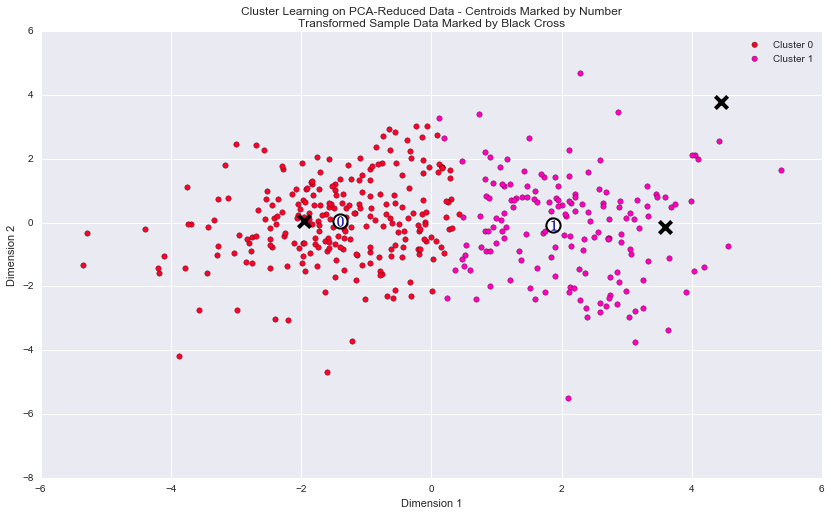

In [15]:
# Display the results of the clustering from implementation
rs.cluster_results(reduced_data, preds, centers, pca_samples)

### Display predicted scored by the model as a contour plot<sup>1</sup>  
The visualization above takes the soft clustering of GMM and simplifies it to hard clustering. Since this effectively simplifies GMM clustering to K-Means, I'd also like to visualize the data in a way that maintains soft clustering. Below I plot ellipses defined by the covariance of the segments. The scaling is a little arbitrary but it gives an idea of how the segments overlap.

This code is modified from the renders.py of this project as well as from http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_classifier.html

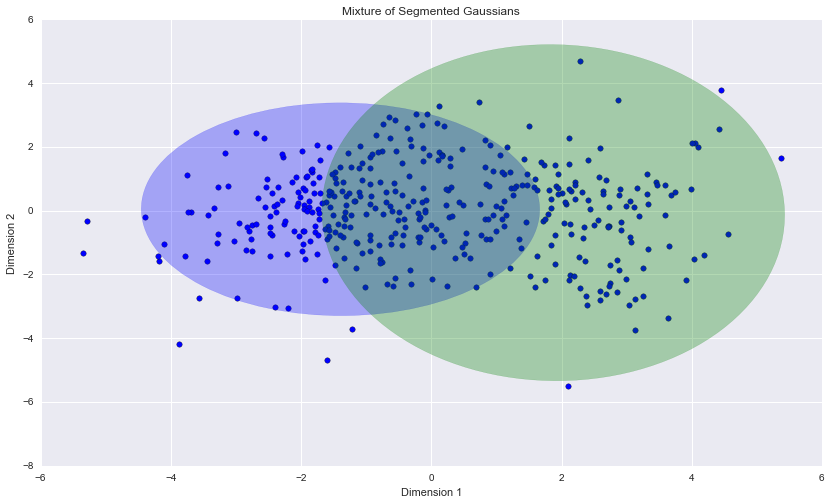

In [16]:
fig = plt.figure(figsize=(14,8))
h = fig.add_subplot(111, aspect='auto')
for n, color in enumerate('bg'):
    v = np.array(clusterer.covars_[n])
    v *= 4
    ell = Ellipse(centers[n], v[0], v[1], 1, color=color)
    ell.set_clip_box(h.bbox)
    ell.set_alpha(0.3)
    h.add_artist(ell)

plt.scatter(reduced_data['Dimension 1'], reduced_data['Dimension 2'], 30.)
plt.title('Mixture of Segmented Gaussians')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Implementation: Data Recovery
Each cluster present in the visualization above has a central point. These centers (or means) are not specifically data points from the data, but rather the *averages* of all the data points predicted in the respective clusters. For the problem of creating customer segments, a cluster's center point corresponds to *the average customer of that segment*. Since the data is currently reduced in dimension and scaled by a logarithm, we can recover the representative customer spending from these data points by applying the inverse transformations.

In the code block below, you will need to implement the following:
 - Apply the inverse transform to `centers` using `pca.inverse_transform` and assign the new centers to `log_centers`.
 - Apply the inverse function of `np.log` to `log_centers` using `np.exp` and assign the true centers to `true_centers`.


In [17]:
# TODO: Inverse transform the centers
log_centers = pca.inverse_transform(centers)

# TODO: Exponentiate the centers
true_centers = np.exp(log_centers)

# Display the true centers
segments = ['Segment {}'.format(i) for i in range(0,len(centers))]
true_centers = pd.DataFrame(np.round(true_centers), columns = data.keys())
true_centers.index = segments
display(true_centers)

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
Segment 0,9124.0,1947.0,2488.0,2057.0,319.0,724.0
Segment 1,4947.0,7164.0,10630.0,1195.0,3734.0,1103.0


### Question 8
Consider the total purchase cost of each product category for the representative data points above, and reference the statistical description of the dataset at the beginning of this project. *What set of establishments could each of the customer segments represent?*  
**Hint:** A customer who is assigned to `'Cluster X'` should best identify with the establishments represented by the feature set of `'Segment X'`.

**Answer:**  
In Segment 0, Fresh and Frozen are higher than the median and the rest are well below their respective medians. It is likely representing resaurants, i.e. establishments which have no use for resale products and where fresh or frozen food is prepared and served. In Segment 1, Milk, Grocery, and Detergents_Paper are nearly in the 75th percentile while the rest hover around the median. It is likely these are retailers, i.e. establishments where unprepared food and household supplies are resold directly.

### Question 9
*For each sample point, which customer segment from* ***Question 8*** *best represents it? Are the predictions for each sample point consistent with this?*

Run the code block below to find which cluster each sample point is predicted to be.

In [18]:
# Display the predictions
for i, pred in enumerate(sample_preds):
    print "Sample point", i, "predicted to be in Cluster", pred

Sample point 0 predicted to be in Cluster 1
Sample point 1 predicted to be in Cluster 0
Sample point 2 predicted to be in Cluster 1


**Answer:**  
*For each sample point, which customer segment from* ***Question 8*** *best represents it?*  
The first sample is high across the board, but Milk, Grocery, and Detergents_Paper are much higher than Fresh and Frozen. It probably belongs in segment 1, the retailer segment. The second sample is dominated by Fresh and while Frozen is low, so are all the segment 1 features. It seems most likely it belongs to segment 0, restaurants. The third sample is a much clearer example of segment 1 as unlike sample 0 fresh and frozen are quite low.

*Are the predictions for each sample point consistent with this?*  
Yes, the samples are clustered just as would be expected by comparing them to the segments.

## Conclusion

In this final section, you will investigate ways that you can make use of the clustered data. First, you will consider how the different groups of customers, the ***customer segments***, may be affected differently by a specific delivery scheme. Next, you will consider how giving a label to each customer (which *segment* that customer belongs to) can provide for additional features about the customer data. Finally, you will compare the ***customer segments*** to a hidden variable present in the data, to see whether the clustering identified certain relationships.

### Question 10
Companies will often run [A/B tests](https://en.wikipedia.org/wiki/A/B_testing) when making small changes to their products or services to determine whether making that change will affect its customers positively or negatively. The wholesale distributor is considering changing its delivery service from currently 5 days a week to 3 days a week. However, the distributor will only make this change in delivery service for customers that react positively. *How can the wholesale distributor use the customer segments to determine which customers, if any, would reach positively to the change in delivery service?*  
**Hint:** Can we assume the change affects all customers equally? How can we determine which group of customers it affects the most?

**Answer:**  
The distributor can draw A/B groups from each of the clusters. That is to say, assume changes will affect the separate segments of customers differently and run an A/B test on each cluster individually, drawing variant and control groups from each without overlap.

### Question 11
Additional structure is derived from originally unlabeled data when using clustering techniques. Since each customer has a ***customer segment*** it best identifies with (depending on the clustering algorithm applied), we can consider *'customer segment'* as an **engineered feature** for the data. Assume the wholesale distributor recently acquired ten new customers and each provided estimates for anticipated annual spending of each product category. Knowing these estimates, the wholesale distributor wants to classify each new customer to a ***customer segment*** to determine the most appropriate delivery service.  
*How can the wholesale distributor label the new customers using only their estimated product spending and the* ***customer segment*** *data?*  
**Hint:** A supervised learner could be used to train on the original customers. What would be the target variable?

**Answer:**  
Train a classifier using the original data with their cluster assignments as the labeled class. Then use it to predict which segment the new customers' estimated spendings belong to.

### Visualizing Underlying Distributions

At the beginning of this project, it was discussed that the `'Channel'` and `'Region'` features would be excluded from the dataset so that the customer product categories were emphasized in the analysis. By reintroducing the `'Channel'` feature to the dataset, an interesting structure emerges when considering the same PCA dimensionality reduction applied earlier to the original dataset.

Run the code block below to see how each data point is labeled either `'HoReCa'` (Hotel/Restaurant/Cafe) or `'Retail'` the reduced space. In addition, you will find the sample points are circled in the plot, which will identify their labeling.

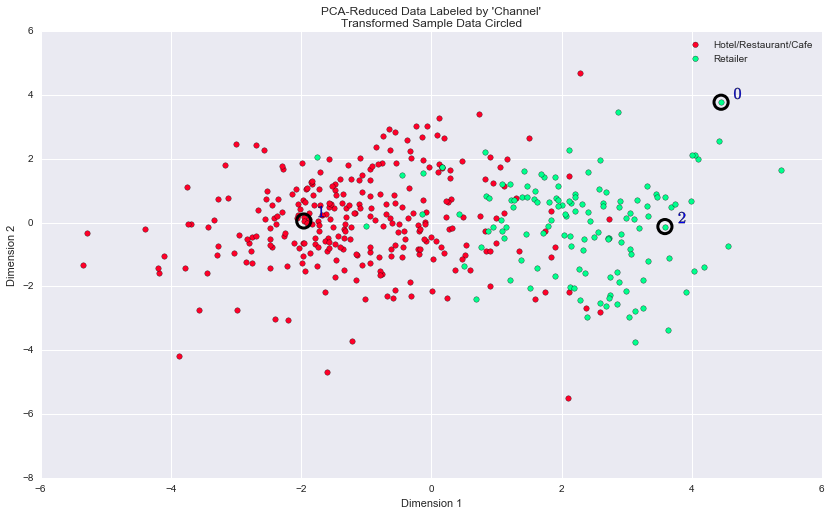

In [19]:
# Display the clustering results based on 'Channel' data
rs.channel_results(reduced_data, outliers, pca_samples)

### Question 12
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers? Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution? Would you consider these classifications as consistent with your previous definition of the customer segments?*

**Answer:**  
*How well does the clustering algorithm and number of clusters you've chosen compare to this underlying distribution of Hotel/Restaurant/Cafe customers to Retailer customers?*  
It compares quite favorably, though it is clearly not suited to hard clustering applied when visualizing the clusters. I feel this shows how using GMM and labeling with probabilities would more accurately represent the segments.

*Are there customer segments that would be classified as purely 'Retailers' or 'Hotels/Restaurants/Cafes' by this distribution?*  
No, the distribution has some clear overlap.

*Would you consider these classifications as consistent with your previous definition of the customer segments?*  
Yes, though in terms of two overlapping gaussians rather than the hard clustering that was actually visualized.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.